In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_curve
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow.keras as keras
from confusion_matrix import plot_confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping  # early stopping
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling1D,
    Input,
    MaxPooling1D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l1

sns.set()

In [23]:
from pylab import rcParams

# rcParams['figure.figsize'] = 12, 8

In [24]:
RANDOM_SEED = 333
np.random.seed(RANDOM_SEED)

In [25]:
CSV_RESULTS_FOLDER = 'csv_results'

# Models

In [26]:
NUM_CLASSES = 2
SEQ_LEN = 50
NUCLEOTIDES_COUNT = 4
EPOCHS = 10
BATCH_SIZE = 100

In [27]:
model1 = Sequential()
model1.add(Conv1D(100, 3, activation='relu', input_shape=(SEQ_LEN, NUCLEOTIDES_COUNT)))
model1.add(Conv1D(100, 3, activation='relu'))
model1.add(MaxPooling1D(3))
model1.add(Conv1D(100, 5, activation='relu',))
model1.add(GlobalAveragePooling1D())
model1.add(Dropout(0.25))
# model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(NUM_CLASSES, activation='softmax'))

model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 48, 100)           1300      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 46, 100)           30100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 100)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 11, 100)           50100     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               12928     
__________

In [28]:
models = {'3 CNN Layers': model1,}

## Prepare data

In [29]:
def one_hot_dna(sequence):
    seq_array = np.array(list(sequence))

    # one hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    # reshape because that's what OneHotEncoder likes
    seq_array = seq_array.reshape(len(seq_array), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array)
    return onehot_encoded_seq

In [30]:
def read_dataframes(target_path, non_target_path):

    with open(target_path, 'r') as file:
        target_sequences = np.array([line.strip().upper() for line in file.readlines() if all(base in set(line) for base in 'ACTG')])
    with open(non_target_path, 'r') as file:
        non_target_sequences = np.array([line.strip().upper() for line in file.readlines() if all(base in set(line) for base in 'ACTG')])

    return (target_sequences, non_target_sequences)


In [31]:
def normalize_datasets(target_sequences, non_target_sequences):
    
    if target_sequences.shape[0] > non_target_sequences.shape[0]:
        target_sequences_n = np.random.choice(
            target_sequences,
            non_target_sequences.shape[0],
        )
        non_target_sequences_n = non_target_sequences
    else:
        target_sequences_n = target_sequences
        non_target_sequences_n = np.random.choice(
            non_target_sequences,
            target_sequences.shape[0],
        )

    X = np.concatenate((target_sequences_n, non_target_sequences_n))
    Y = pd.Series(np.append(
        np.full(target_sequences_n.shape[0], 1),
        np.full(non_target_sequences_n.shape[0], 0))
    )
    
    X = np.array([one_hot_dna(line) for line in X])
    Y = keras.utils.to_categorical(Y)
    
    return (X, Y)


In [49]:
def compute_metrics(X, Y, model):
    # ROC vars
    tprs = []
    aucs, acc, rec, prec = [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    # Precision-recall vars
    precisions = []
    best_precision = {"precision_score": 0.0, "precision": None, "recall": None}

    folded_data = KFold(n_splits=2, random_state=RANDOM_SEED, shuffle=True)

    for k, (train, test) in enumerate(folded_data.split(X, Y)):
        Y_test_flat = np.array(list(map(lambda x: x[1] == 1 and 1 or 0, Y[test])))
        model.fit(
            X[train],
            Y[train],
            # Keras special args
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            validation_split=0.1,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            )
        probas_ = model.predict(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y_test_flat, probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        Y_pred = model.predict_classes(X[test])

        acc.append(accuracy_score(Y_test_flat, Y_pred))
        prec.append(precision_score(Y_test_flat, Y_pred))
        rec.append(recall_score(Y_test_flat, Y_pred))
        # Compute precision, recall
        precision, recall, _ = precision_recall_curve(Y_test_flat, probas_[:, 1])
        average_precision = average_precision_score(Y_test_flat, probas_[:, 1])
        if average_precision > best_precision["precision_score"]:
            best_precision["precision"] = precision
            best_precision["recall"] = recall
            best_precision["precision_score"] = average_precision
        precisions.append(average_precision)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

        
    return mean_fpr, mean_tpr, best_precision


In [50]:
def run_experiment(datasets, model, model_name):
    '''
    datasets: a dict like {
    'L1': 'data_link/L1/data/all_50_last.txt',
    'p_pseudo': 'pseudogenes_50_last.txt',
    }
    model: keras model
    model_name: str
    '''

    CLASS_1, CLASS_2 = datasets.keys()
    target_path, non_target_path = datasets.values()
    # Read data
    target_sequences, non_target_sequences = read_dataframes(target_path, non_target_path)
    X, Y = normalize_datasets(target_sequences, non_target_sequences)

    # Use 5 fold to evaluate model
    mean_fpr, mean_tpr, best_precision = compute_metrics(X, Y, model)

    # Create file names
    CSV_FILE_SUBNAME_OBJECTS = f"{CLASS_1}_vs_{CLASS_2}" # "True_vs_False"
    CSV_FILE_SUBNAME = f"{CSV_FILE_SUBNAME_OBJECTS}_{model_name}"
    
    # Write results to csv
    # ROC
    pd.DataFrame({
        "fpr": mean_fpr,
        "tpr": mean_tpr
    }).to_csv(
        f"{CSV_RESULTS_FOLDER}/ROC__{CSV_FILE_SUBNAME}.csv",
        index=False
    )
    # Precision-recall
    pd.DataFrame({
        "precision": best_precision["precision"],
        "recall": best_precision["recall"]
    }).to_csv(
        f"{CSV_RESULTS_FOLDER}/Precision-Recall__{CSV_FILE_SUBNAME}.csv",
        index=False
    )
    #     pd.DataFrame(fi).to_csv("Feature_importance__{0}.csv".format(CSV_FILE_SUBNAME), index=False)







# Experiments

In [51]:
experiments = [
    {
    'L1': 'data_link/L1/data/all_50_last.txt',
    'p_pseudo': 'pseudogenes_50_last.txt',
    },
    
]

In [52]:
for model_name, model in models.items():
    for experiment_dataset in experiments:
        run_experiment(experiment_dataset, model, model_name)

Train on 5959 samples, validate on 663 samples
Epoch 1/10
5959/5959 [==============================] - 1s 137us/sample - loss: 0.0051 - acc: 0.9988 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2/10
5959/5959 [==============================] - 1s 136us/sample - loss: 0.0062 - acc: 0.9971 - val_loss: 0.0227 - val_acc: 0.9940
Epoch 3/10
5959/5959 [==============================] - 1s 137us/sample - loss: 0.0039 - acc: 0.9990 - val_loss: 0.0108 - val_acc: 0.9955
Epoch 4/10
5959/5959 [==============================] - 1s 138us/sample - loss: 7.1727e-04 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 0.9985
Epoch 5/10
5959/5959 [==============================] - 1s 138us/sample - loss: 5.1959e-04 - acc: 0.9998 - val_loss: 0.0151 - val_acc: 0.9955
Epoch 6/10
5959/5959 [==============================] - 1s 137us/sample - loss: 4.8239e-04 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 0.9970
Train on 5959 samples, validate on 663 samples
Epoch 1/10
5959/5959 [==============================] - 1s 137us/s

## Model 

In [10]:
# print(tf.VERSION)
# print(keras.__version__)

In [10]:
# history = model.fit(
#     X_train, Y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     verbose=1,
#     validation_split=0.1,
#     callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
# )

In [15]:
# # New
# score = model.evaluate(X_test, Y_test,
#                        batch_size=batch_size, verbose=1)
# print('\n')
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

3311/3311 [==============================] - 0s 87us/sample - loss: 0.0194 - acc: 0.9937


Test score: 0.019373496186254842
Test accuracy: 0.9936575


In [16]:
# Y_pred = model.predict_classes(X_test, verbose=1)

3311/3311 [==============================] - 0s 112us/sample


Normalized confusion matrix
[[0.99701136 0.00298864]
 [0.00976801 0.99023199]]


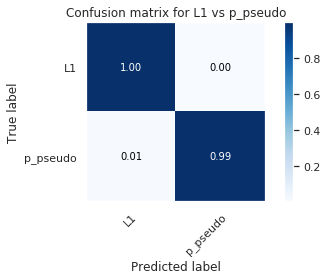

In [17]:
# Y_test_flat = np.array(list(map(lambda x: x[1]==1 and 1 or 0, Y_test)))
# with sns.axes_style("darkgrid", {"axes.grid": False}):
#     plot_confusion_matrix(
#         Y_test_flat,
#         Y_pred,
#         classes=np.array(CLASS_NAMES),
#         normalize=True,
#         title=f'Confusion matrix for {CLASS_NAMES[0]} vs {CLASS_NAMES[1]}'
#     )

In [18]:
# Y_pred_probas = model.predict(X_test, verbose=1)[:,1]
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test_flat, Y_pred_probas)
# auc_keras = auc(fpr_keras, tpr_keras)

3311/3311 [==============================] - 0s 114us/sample


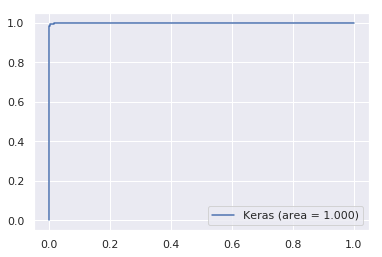

In [19]:
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.legend(loc='lower right')

# Trash

In [5]:
# with open('data_link/L1/data/all_50_last.txt', 'r') as file:
#     target_sequences = np.array([line.strip().upper() for line in file.readlines() if all(base in set(line) for base in 'ACTG')])
# with open('pseudogenes_50_last.txt', 'r') as file:
#     non_target_sequences = np.array([line.strip().upper() for line in file.readlines() if all(base in set(line) for base in 'ACTG')])
# CLASS_NAMES = ['L1', 'p_pseudo']



